# **Connect4 game with Deep Q-Learning**

# **Introduction**
The goal of any optimization problem is to find an optimal set of actions that maximizes/minimizes a certain cost function. A brute force method that finds an optimal strategy is often an NP problem which makes it unfeasible to solve in a finite time. Therefore, we opt for approximate dynamic programming in order to find either an optimal or sub-optimal set of decisions. 

## **Dynamic Programming**
Dynamic Programming (DP) is a method for finding optimal solution of a given problem by dividing it into smaller subproblems such that the solving these subproblems lead to solving the original scenario. To put it in simpler words, given a state $S_{t}$ and a cost function $C_{t}$, the optimal decision $a_{S_{t}}$ would depend on the next state. Therefore we can reformulate the problem to: $Solution_{S_{t}}$=f($Solution_{S_{t+1}}$).

## **Approximate Dynamic Programming**
So far we know that applying DP to find an optimal solution to a given problem leads to dividing the problem into subproblems. In an Approximate Dynamic Programming (ADP), the choice of the optimal decision for a given problem/subproblem depends on a value function for each state. In other words, we rank the benefit/importance of a particular action by the value of the state it redirects to. <br> Each state has its own value, thus, at every time step, we approximate these values by updating them using the Bellman Equation. Therefore, the approximated value function will be updated after each time step using the following equation: <br><br><br>

<center>$V(S_{t})$=$\max_{a_{t}}$($C(S_{t})$ + $\sum_{s' \in S}$ (p(s'| $S_{t}$,$a_{t}$) $\times$ $V(s'_{t+1})$)</center> <br><br>

## **Reinforcement Learning**
The goal of reinforcement learning is to maximize an agent's reward by performing a series of actions in response to a dynamic environment.

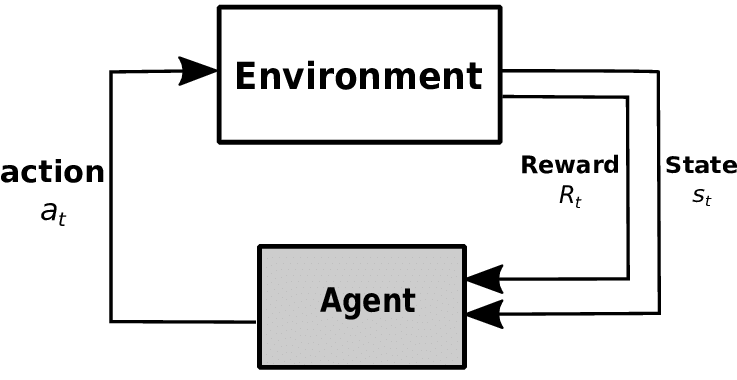

The following are some key concepts that describe the fundamental parts of an RL problem: :<br>
* **Environment**: The physical environment in which the agent operates.<br>
* **State**: The agent's current status <br>
* **Reward**: Feedback from the environment<br>
* **Policy**: A method for mapping the state of an agent to actions. <br>
* **Value**: Future reward that an agent will earn if he takes a specific action in a specific state <br>



RL algorithms are divided into two types: 


1.  An algorithm that calculates the optimal policy without using or estimating the transition and reward functions is known as a **model-free algorithm**. 
2.   An algorithm that determines the optimal policy using The transition and the reward function is known as **model-based algorithm**.




# **Q-learning model**

**Q-learning** is a model-free algorithm that can be used to create a self-playing Connect4 agent.
It is based on the concept of updating Q values, which represent the value of doing an action **a** in state **s**.
The Q-learning algorithm is built around the following value updating rule. 

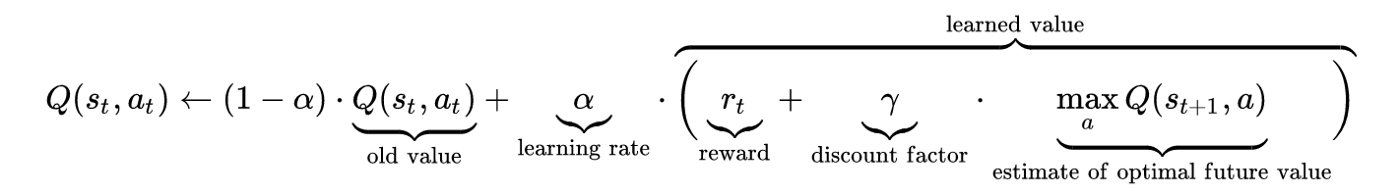

The agent maintains a Q(S,A) table, where S denotes the set of states and A denotes the set of actions. 
the Q-Table is used to compute the maximum expected future rewards for an action **a** at each state.
<br>
The equation above simply updates the specific location of the Q-Table that corresponds to the current observation based on the expected reward. 

The state of a Connect 4 board during a game is shown in the image above as an example observation from the standpoint of the Connect 4 environment, to gain a better understanding of Q-learning  

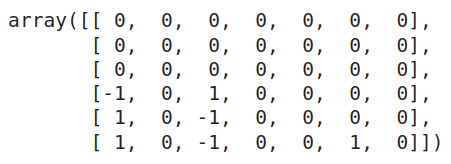

The agent receives this arrangement of previously played coins as an observation and stores it in the Q-Table. <br>
Basically, the agent will question himself what he did the last time he encountered this observation and what action he will take to do better this time. 

# **The Limitations of Q-Learning**

We may try to store all potential (action, state) combinations and compute the optimal action if we played a smaller game.<br>
In its most basic form, Connect Four has 4531985219092 unique possible states.
It is impossible to keep track of all of these combinations due to hardware limitations. <br>
If we suppose that there is some form of algorithm that can take an observation, along with some sort of loss function calculated from the reward, and generalize about the observed environment in order to choose a single output (or action), we won't have to store as many environment observations. Fortunately,
Deep Neural Networks are a technology aimed at just this problem.

To summarize, we will employ a typical Q-Learning structure with a simple substitution of a Q-Table with a Deep Neural Network to reduce the enormous size of our observation space. 

## **The Deep Q-Network Algorithm**

A Neural Network maps input states to (action, Q-value) pairs 

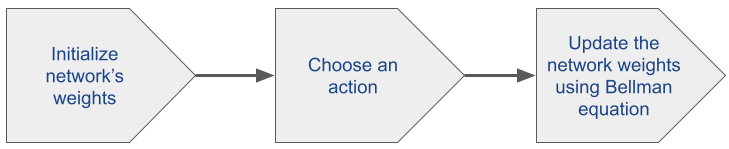

1.   Initialize Main and Target neural networks
2.   Use the Ɛ-Greedy Exploration Strategy to choose an action.
3.   Use the Bellman Equation to update network weights.

### **Initialize your Target and Main neural networks**

Deep Q-Learning, essentially, substitutes the traditional Q-table with a neural network.
A neural network maps input states to (action, Q-value) pairs rather than mapping a state-action pair to a q-value. <br>


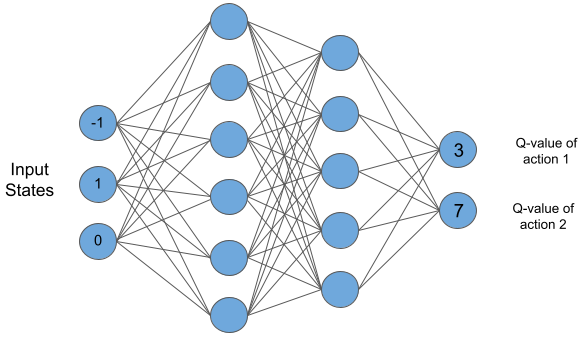

One of the most notable characteristics of Deep Q-Learning is that it employs two neural networks in the learning process.
The architecture of these networks is the same, but the weights are different.
The weights from the main network are passed to the target network every N ( N is a Hyperparameter ) steps.
When both of these networks are used, the learning process becomes more stable, and the algorithm learns more effectively.
Every 100 steps, the main network weights replace the target network weights in our implementation. 

The input states are mapped to a (action, q-value) pair by the main and target neural networks.
Each output node (representing an action) in this scenario holds the q-value of the action as a floating point number.
Because the output nodes do not reflect a probability distribution, their sum will not equal 1.
One action has a Q-value of 3 in the example above, whereas the other has a Q-value of 7. 

3. ### **The Huber Loss Function**

The MSE is known for recognizing outliers, whereas the MAE is known for ignoring them.<br>
By balancing the MSE and MAE together, the Huber Loss gives the best of the two.
The Huber loss function us defined as follows<br>

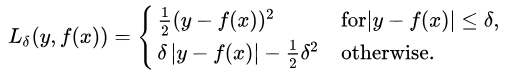

The MSE should be used for loss values less than delta, while the MAE should be used for loss values more than delta.
This effectively combines the greatest features of both loss functions!<br>

When we use the MAE for bigger loss values, we reduce the weight assigned to  outliers while still getting a well-rounded model.<br>
In order to keep a quadratic function near the center, we apply the MSE for the smaller loss values.<br>

As long as the loss values are greater than 1, this has the effect of amplifying them.
When the loss for those data points goes below 1, the quadratic function down weights them, allowing the training to focus on the data points with higher error rates. <br>

### **Use the Ɛ-Greedy Exploration Strategy to choose an action.**

The agent in the Ɛ-Greedy Exploration strategy picks a random action with probability epsilon and exploits the best known action with probability 1 — Ɛ.

1. ### **Selecting the optimal action to take based on network output**

The Main and Target models map input states to the Q-values of the predicted actions.<br>
In this situation, the best action at that state is the action with the highest predicted Q-value. 

### **Use the Bellman Equation to update network weights.**

After selecting an action, the agent must carry it out and update the Main and Target networks in accordance with the Bellman equation.<br>
Deep Q-Learning agents leverage Experience Replay to learn about their environment and keep the Main and Target networks up to date.<br> 
To recapitulate, every four steps, the primary network samples and trains on a batch of previous experiences.<br>
Every 100 steps, the primary network weights are transferred to the target network weights. 

### **Experience replay memory**

The act of storing and replaying game states (the state, action, reward, and next state) from which the RL algorithm could learn is known as experience replay.<br>
Off-Policy algorithms can employ Experience Replay to learn in an offline environment.
Off-policy approaches can use saved and stored information from prior operations to adjust the algorithm's parameters.<br>
Deep Q-Learning learns in smaller batches to prevent skewing the dataset distribution of distinct states, actions, rewards, and next states that the neural network will observe.<br>
Notably, the agent is not required to train after each stage.
In our system, we use Experience Replay to train in small batches every four steps rather than every step. 

### **Bellman Equation**

The agent should likewise update our model weights according to the Bellman Equation, exactly like in vanilla Q-Learning. 

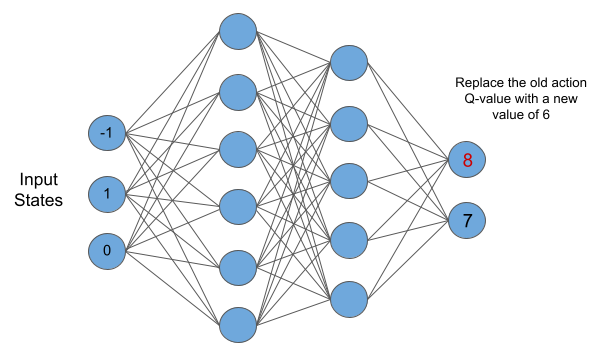

We intend to use our neural network rather than a Q-table to reproduce the Temporal Difference target operation from the original Bellman equation in Figure above.<br>
It is important to note that the Temporal Difference target is calculated using the target network rather than the main network. Assuming the temporal difference target operation returns a value of 8 in the preceding example, we can update the main network weights by assigning 8 to the target q-value and fitting our main network weights to the new target values.

In [1]:
#@title Our project dependencies 
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

from collections import deque
import time
import datetime
import random
import copy

In [2]:
#@title Loading the TensorBoard notebook extension
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/


In [3]:
#@title Connect 4 custom environment definition 
class CustomEnv(Env):
    NUM_ROWS = 6
    NUM_COLS = 7
    NUM2WIN = 4
    def __init__(self):
        # Actions we can take: throw the rock in one of the 7 column
        self.action_space = Discrete(self.NUM_COLS)
        # state matrix
        self.observation_space = Box(low=np.array([-1 for i in range(7*6)]).reshape(6,7), 
                                     high=np.array([1 for i in range(7*6)]).reshape(6,7),
                                     dtype=np.int8)
        # starting borad matrix
        self.state = np.zeros((6,7))
        
    def step(self, action,player): 
        #action= column number
        # throw the coin on the top of the existing/empty selected column
        j = 0
        while j + 1 < self.NUM_ROWS and self.state[j + 1][action] == 0:
            j += 1
        info = {}    
        if self.state[j][action]!=0:
          self.state[j][action]!=np.nan
          reward=-10000
          done=True
          winner="overflow"
          info["winner"]=winner
          return self.state,reward,done,info
        self.state[j][action] = player

        winner=""
        # reward
        done = False
        reward = 0
        for i in range(self.NUM_ROWS - self.NUM2WIN + 1):
            for j in range(self.NUM_COLS - self.NUM2WIN + 1):
                sub_state = self.state[i:i + self.NUM2WIN, j:j + self.NUM2WIN]
                if np.max(np.sum(sub_state, axis=0)) == self.NUM2WIN or np.max(np.sum(sub_state, axis=1)) == self.NUM2WIN or np.trace(sub_state) == self.NUM2WIN or np.trace(np.transpose(sub_state)) == self.NUM2WIN: # human having 4 consecutive pieces in a column or row or both diagonals
                    done = True
                    reward = 10
                    winner="Agent"
                elif np.min(np.sum(sub_state, axis=0)) == -self.NUM2WIN or np.min(np.sum(sub_state, axis=1)) == -self.NUM2WIN or np.trace(sub_state) == -self.NUM2WIN or np.trace(np.transpose(sub_state)) == -self.NUM2WIN:
                    done = True
                    reward = -10
                    winner="Human"
                else: 
                    reward=0  

        info["winner"]=winner
        
        # Return step information
        return self.state, reward, done,info
    
    def reset(self):
        # Reset
        self.state = np.zeros((6,7))
        return self.state

## **Minimax Algorithm**

Minimax is a decision-making algorithm that is commonly used in two-player turn-based games. The algorithm's goal is to find the optimal next move.

In the algorithm, one player is referred to as the maximizer, while the other is referred to as the minimizer.
If we assign an evaluation score to the game board, one player attempts to select the game state with the highest score, while the other selects the one with the lowest score. 

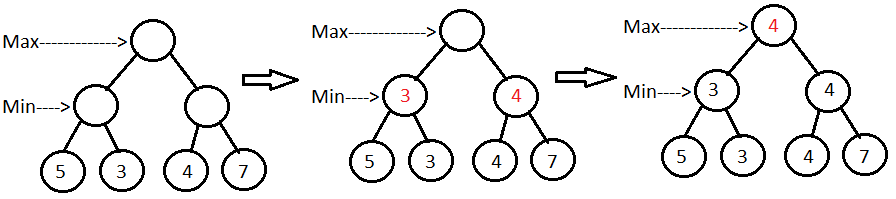

The pseudo-code of minimax is as follows <br>

1.   Construct the entire game tree.
2.   Using the evaluation function, compute scores for leaves.
3.   Back-up scores from leaves to roots, taking into account the player type:
    *   Choose the node with the highest score for the maximizer.
    *   Choose the node with the lowest score for the minimizer.
4.  Choose the node with the highest value at the root node and make the associated move. 








In [4]:
#@title Minimax Algorithm related Constants
# Minimax Algorithm related Constants
AI_PIECE = 1
P_PIECE = -1
EMPTY_PIECE = 0
ROWS = 6
COLUMNS = 7
LENGTH = 4

In [5]:
#@title Minimax algorithm
def player_move(board):

    action = int(input("Enter your move!\n"))
    while not valid_action(board, action):
        action = int(input("Your move was not valid, please enter a valid move!\n"))
    return action


def valid_action(board, action):
  
    return 0 <= action <= COLUMNS and board[0][action] == 0


def evaluate_interval(interval):

    score = 0

    if interval.count(AI_PIECE) == 3 and interval.count(EMPTY_PIECE) == 1:
        score += 5

    if interval.count(AI_PIECE) == 2 and interval.count(EMPTY_PIECE) == 2:
        score += 2

    if interval.count(P_PIECE) == 3 and interval.count(EMPTY_PIECE) == 0:
        score -= 4

    return score


def evaluate(board):

    score = 0

    # Central Nodes
    center_array = [int(i) for i in list(board[:, COLUMNS // 2])]
    center_count = center_array.count(AI_PIECE)
    score += center_count * 3

    # Horizontal Nodes
    for r in range (ROWS):
        row = [int(i) for i in list(board[r, :])]
        for c in range(COLUMNS - 3):
            interval = row[c: c + LENGTH]
            score += evaluate_interval(interval)

    # Vertical Nodes
    for c in range (COLUMNS):
        column = [int(i) for i in list(board[:, c])]
        for r in range(ROWS - 3):
            interval = column[r: r + LENGTH]
            score += evaluate_interval(interval)

    # Positive Diagonal
    for r in range(ROWS - 3):
        for c in range(COLUMNS - 3):
            interval = [board[r + i][c + i] for i in range(LENGTH)]
            score += evaluate_interval(interval)

    # Negative Diagonal
    for r in range(ROWS - 3):
        for c in range(COLUMNS - 3):
            interval = [board[r + 3 - i][c + i] for i in range(LENGTH)]
            score += evaluate_interval(interval)

    return score


def winning_move(board, piece):

    # Horizontal Nodes
    for r in range(ROWS):
        row = [int(i) for i in list(board[r, :])]
        for c in range(COLUMNS - 3):
            interval = row[c: c + LENGTH]
            if interval.count(piece) == 4:
                return True

    # Vertical Nodes
    for c in range(COLUMNS):
        column = [int(i) for i in list(board[:, c])]
        for r in range(ROWS - 3):
            interval = column[r: r + LENGTH]
            if interval.count(piece) == 4:
                return True

    # Positive Diagonal
    for r in range(ROWS - 3):
        for c in range(COLUMNS - 3):
            interval = [board[r + i][c + i] for i in range(LENGTH)]
            if interval.count(piece) == 4:
                return True

    # Negative Diagonal
    for r in range(ROWS - 3):
        for c in range(COLUMNS - 3):
            interval = [board[r + 3 - i][c + i] for i in range(LENGTH)]
            if interval.count(piece) == 4:
                return True


def terminal_state(board, valid_moves):
    return winning_move(board, AI_PIECE) or winning_move(board, P_PIECE) or len(valid_moves) == 0


def available_moves(board):
    return set(i for i in range(COLUMNS) if board[0][i] == 0)


def drop_piece(board, action, player):
    for i in list(reversed(range(ROWS))):
        if np.any(board[i][action] == 0):
            board[i][action] = player
            return


def minimax(board, depth, alpha, beta, maximize):

    valid_moves = available_moves(board)
    terminal = terminal_state(board, valid_moves)

    if depth == 0 or terminal:

        if terminal:
            if winning_move(board, AI_PIECE):
                return None, 10000000000000
            elif winning_move(board, P_PIECE):
                return None, (-1000000000000)
        else:
            return None, evaluate(board)

    if maximize:

        value = -math.inf
        column = random.choice(list(valid_moves))

        for action in valid_moves:
            b_copy = copy.deepcopy(board)
            drop_piece(b_copy, action, AI_PIECE)
            score = minimax(b_copy, depth - 1, alpha, beta, False)[1]

            if score > value:
                value = score
                column = action

            alpha = max(alpha, value)

            if alpha >= beta:
                break

        return column, value

    else:

        value = math.inf
        column = random.choice(list(valid_moves))

        for action in valid_moves:
            b_copy = copy.deepcopy(board)
            drop_piece(b_copy, action, P_PIECE)
            score = minimax(b_copy, depth - 1, alpha, beta, True)[1]

            if score < value:
                value = score
                column = action

            beta = min(beta, value)

            if alpha >= beta:
                break

        return column, value

In [30]:
#@title Output of the Minimax algorithm for an observation given as input
obs = np.array([[0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [-1,0,0,0,0,0,0],
                [1,0,-1,0,0,0,0],
                [1,0,-1,0,1,0,0],])
action, value =minimax(obs, 3, -math.inf, math.inf, True)
print('The input observation \n')
print(obs)
print('\naction (selected column): ', action)
print('\nQ-value: ', value)

The input observation 

[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0 -1  0  0  0  0]
 [ 1  0 -1  0  1  0  0]]

action (selected column):  3

Q-value:  9


## **Self-supervised learning**

Self-supervised learning is a means for training computers to do tasks without humans providing labeled data (i.e., a picture of a dog accompanied by the label “dog”). It is a subset of unsupervised learning where outputs or goals are derived by machines that label, categorize, and analyze information on their own then draw conclusions based on connections and correlations. <br>

Self-supervised learning can also be an autonomous form of supervised learning because it does not require human input in the form of data labeling. In contrast to unsupervised learning, self-supervised learning does not focus on clustering and grouping that is commonly associated with unsupervised learning. [[1]](https://www.techslang.com/definition/what-is-self-supervised-learning/)

We employed a self-supervised learning strategy in our implementation, where the network takes a batch of previously observations with their predicted  Q-values and adjusts his weights based on them. 

In [7]:
#@title Shape of Action space & state space 
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = CustomEnv()
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))
# An episode represents a full game

Action Space: Discrete(7)
State space: Box(-1, 1, (6, 7), int8)


In [8]:
#@title The model architecture
def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    print("state_shape: ",state_shape)
    print("action shape: ",action_shape)
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(150,(3,3), input_shape=(6,7,1), activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu', kernel_initializer=init,
    kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=keras.regularizers.l2(1e-4),
    activity_regularizer=keras.regularizers.l2(1e-5)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu', kernel_initializer=init,
    kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=keras.regularizers.l2(1e-4),
    activity_regularizer=keras.regularizers.l2(1e-5)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    return model

model = agent(env.observation_space.shape, env.action_space.n)
print(model.summary())

state_shape:  (6, 7)
action shape:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 5, 150)         1500      
                                                                 
 dropout (Dropout)           (None, 4, 5, 150)         0         
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 50)                150050    
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropou

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# @title Model training function
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.9 # Learning rate
    discount_factor = 0.75

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    env.reset()
    batch_size = 64 * 2
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:

            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        X.append(observation)
        Y.append(current_qs)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(np.array(X), np.array(Y), batch_size=batch_size,epochs=10, verbose=0, shuffle=True, callbacks=[tensorboard_callback])

In [ ]:
# @title Putting all together
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01
train_episodes = 1000
test_episodes = 500
reward_hist=[]

# 1. Initialize the Target and Main models
# Main Model (updated every 4 steps)
model = agent(env.observation_space.shape, env.action_space.n)
# Target Model (updated every 100 steps)
target_model = agent(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)
eps_l=[]
target_update_counter = 0
X = []
y = []

steps_to_update_target_model = 0
n_wins=0
train_list_performace=[]
for episode in range(train_episodes):
    total_training_rewards = 0
    observation = env.reset()
    done = False
    human_play=True
    stop=1000
    
    while not done:
        if human_play:
          if np.random.rand()<0.4:
            action,value =minimax(observation, 2, -math.inf, math.inf, True)
            try:
              if type(action)==int:
                observation,_,_,info=env.step(action,-1)
              else: 
                action=action[0] 
                observation,_,_,info=env.step(action,-1)
            except: 
              print("Wrong selected action was: {}".format(action))
              action=np.random.choice([i for i in range(7)])
              observation,_,_,info=env.step(action,-1)
            while info["winner"]=="overflow":
                action = np.random.choice(np.arange(0,7))
                observation,_,_,info=env.step(action,-1)
          else:
                 action = np.random.choice(np.arange(0,7))
                 observation,_,_,info=env.step(action,-1)   
          human_play=False  
        
        else:
          stop-=1
          steps_to_update_target_model += 1
          human_play=True
          random_number = np.random.rand()
          # 2. Explore using the Epsilon Greedy Exploration Strategy
          if random_number <= epsilon:
              # Explore
              action = env.action_space.sample()
              # print("Taking a random walk with epsilon: {}".format(epsilon))
          else:
              # Exploit best known action
              # model dims are (batch, env.observation_space.n)
              encoded = observation
              #encoded_reshaped = encoded.reshape(1,encoded_reshaped[0],encoded_reshaped[1],1)
              predicted = model.predict(np.expand_dims(observation,axis=0))
              action = predicted.argmax()

          temp=env.state   
          new_observation, reward, done, info = env.step(action,1)
          if info["winner"]=="overflow":
              new_observation=env.reset()
              # print(f" {'*'*30} OVERFLOW {'*'*30} with a reward: {reward} and done is {done}")

          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation
          if steps_to_update_target_model % 100 == 0 or done:
              train(env, replay_memory, model, target_model, done)

          observation = new_observation
          total_training_rewards += reward
          
          if done:
              print(f'Training at epoch Total {episode}, training rewards: {total_training_rewards} after n steps = {episode} \
              with final reward = {reward} with a winner :{info["winner"]}')

              if info["winner"]=="Agent":
                n_wins+=1
              else:
                n_wins=max(n_wins-1,0) 
              train_list_performace.append(n_wins)   
              #total_training_rewards += 1

              if steps_to_update_target_model >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps_to_update_target_model = 0
              break
          # else:
          #   if episode % 10  == 0:
          #     print("Training at epoch = {}, with a reward {}".format(episode,reward))
        
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    eps_l.append(epsilon)
    reward_hist.append(total_training_rewards)
env.close()    
target_model.save_weights("Target.h5")
model.save_weights("Main.h5")


In [ ]:
%tensorboard --logdir logs/fit

### **Tensorboard plots**

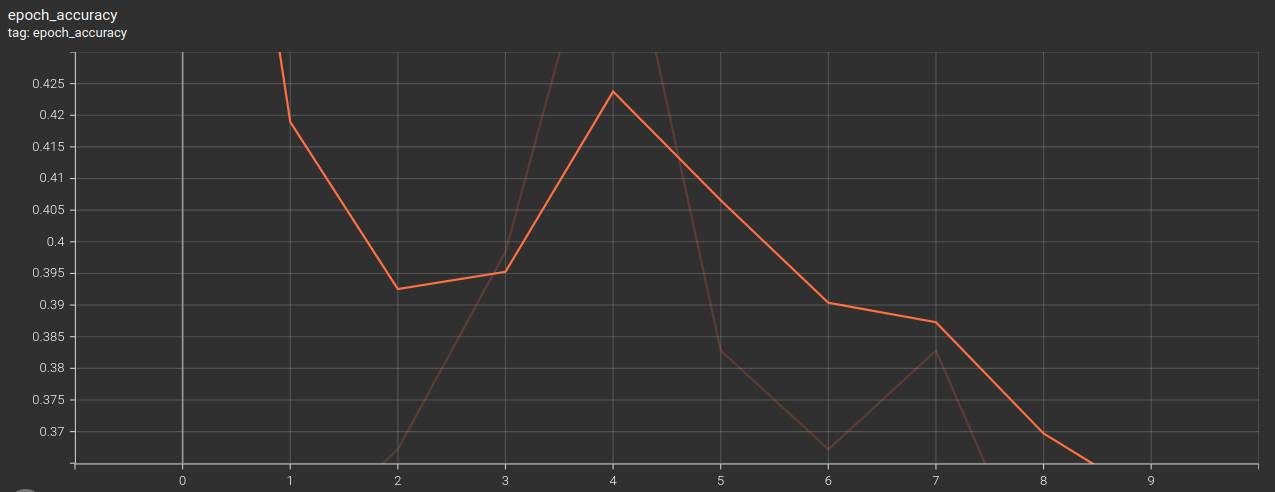

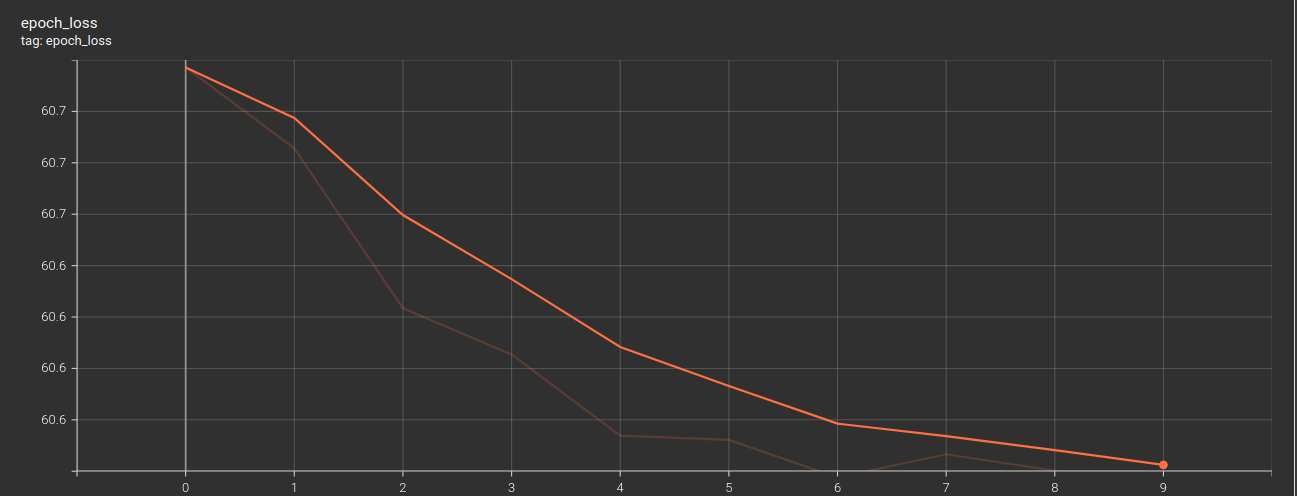

In [ ]:
#@title Testing the trained model
episodes =100
n_wins=0
for episode in range(1, episodes+1):
    current_state = env.reset()
    done = False
    score = 0 
    human_play=True
    while not done:
        if human_play:
          env.step(np.random.choice(np.arange(0,7)),1)
          human_play=False
          continue
        else: 
          action = model.predict(np.expand_dims(current_state,axis=0)).argmax(axis=1)
          current_state, reward, done, info = env.step(action,-1)
          score+=reward
          human_play=True
    if done:
      print("Game was done at episode {} with a score of {}".format(episode,score))   
      if info["winner"]=="Agent":
        n_wins+=1   
    print('Episode:{} Score:{}'.format(episode, score))

print("Total iterations won by agent is: {}".format(n_wins))

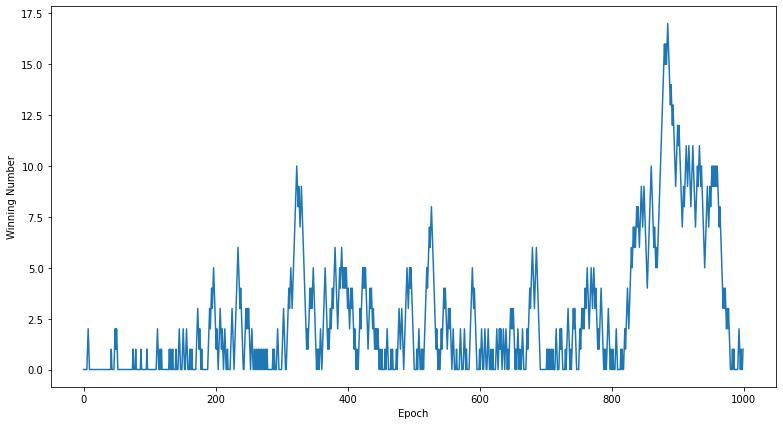

In [18]:
#@title number of wins per epochs
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Winning Number")
plt.plot(range(0,len(train_list_performace)),train_list_performace);

In the above graph, we saw that the average of the number of wins during training is increasing when we move further into the training. We also noticed that the curve isn't smooth which is mainly due to the overflow condition. Basically the game ends by one of the players picking up an action that requires placing the token in a full column. 

Text(0.5, 1.0, 'Evolution of the Exploration Rate')

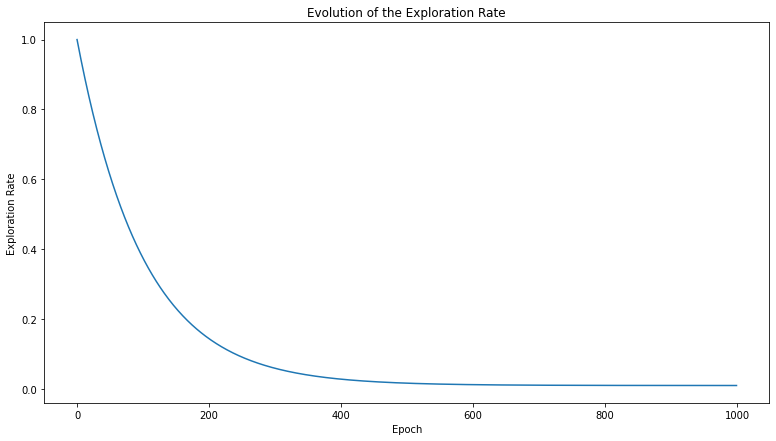

In [19]:
#@title Evolution of the Exploration Rate
fig,ax=plt.subplots(figsize=(13,7))
plt.plot(range(len(eps_l)),eps_l)
plt.xlabel("Epoch")
plt.ylabel("Exploration Rate")
plt.title("Evolution of the Exploration Rate")

In this graph, we can see how the exploration rate decreases as we move deeper in the training piepline. This was done explicitly so that the agent can explore the possible states and approximate their values. This exploration lead to a worse performance in the early epochs since the RL-agent was yet to learn the observation space.

# Conclusion
Finally we saw that the agent has started to outperform a purely greedy algorithm in the last epochs since it learned a better strategy while not using a brute-force-like method to establish the optimal action. We also saw the model has yet to learn how to not take the forbidden actions. We can work more on this axis by using a guided environmet i.e, specifying to the model the set of possible actions at each observation. Moreover, we have to work more on tunning the DQN since the overall collected reward isn't optimal. 

In [25]:
!jupyter nbconvert --to html /content/c41.ipynb

[NbConvertApp] Converting notebook /content/c41.ipynb to html
[NbConvertApp] Writing 1042096 bytes to /content/c41.html
